In [24]:
# ================================================================
# Step 1: Import Libraries
# ================================================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [25]:
# Base dataset path
DATASET_PATH = "/kaggle/input/df-images-model/Deepfake Images dataset"

# Image size (resize all images)
IMG_SIZE = 128


In [26]:
def extract_prnu(img):
    denoised = denoise_wavelet(img, channel_axis=None, rescale_sigma=True)
    prnu = img - (denoised * 255).astype(np.uint8)
    return prnu

def extract_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift)+1)
    return magnitude_spectrum

def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    prnu = extract_prnu(img)
    fft = extract_fft(img)
    combined = np.stack([img, prnu, fft], axis=-1)
    return combined


In [27]:
def load_dataset(base_path):
    X, y = [], []
    
    for label, folder in enumerate(["Real Images", "Fake Images"]):
        folder_path = os.path.join(base_path, folder)
        if not os.path.exists(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        for file in os.listdir(folder_path):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(folder_path, file)
                try:
                    features = preprocess_image(path)
                    X.append(features)
                    y.append(label)
                except Exception as e:
                    print(f"Error with {path}: {e}")
    return np.array(X), np.array(y)

# Load images
X, y = load_dataset(DATASET_PATH)
print("Loaded images:", X.shape)
print("Loaded labels:", y.shape)


Loaded images: (30, 128, 128, 3)
Loaded labels: (30,)


In [28]:
# Normalize to [0,1]
X = X / 255.0

# One-hot encode labels
y = to_categorical(y, num_classes=2)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (24, 128, 128, 3) (24, 2)
Test set: (6, 128, 128, 3) (6, 2)


In [29]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-20 11:19:06.860783: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=8,
    verbose=1
)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.3438 - loss: 1.4105 - val_accuracy: 0.6667 - val_loss: 0.6118
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3854 - loss: 0.7408 - val_accuracy: 0.6667 - val_loss: 0.6394
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6615 - loss: 0.6682 - val_accuracy: 0.6667 - val_loss: 0.6243
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7865 - loss: 0.6232 - val_accuracy: 0.8333 - val_loss: 0.5236
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6458 - loss: 0.5665 - val_accuracy: 0.8333 - val_loss: 0.5712
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8646 - loss: 0.3912 - val_accuracy: 0.6667 - val_loss: 0.4200
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8698 - loss: 0.4013 - val_accuracy: 0.8333 - val_loss: 0.4686
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8385 - loss: 0.3016 - val_accuracy: 0.8333 - val_loss:

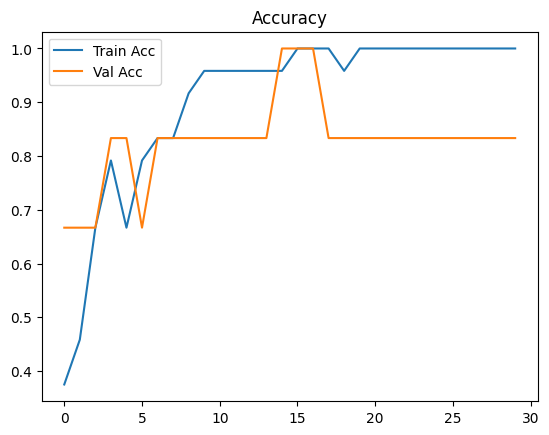

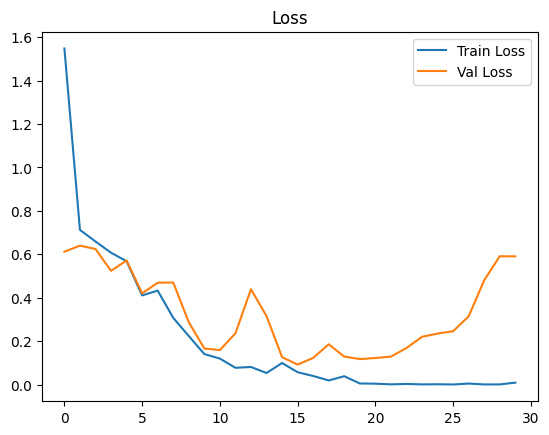

In [32]:
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
              precision    recall  f1-score   support

        REAL       0.67      1.00      0.80         2
        FAKE       1.00      0.75      0.86         4

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6



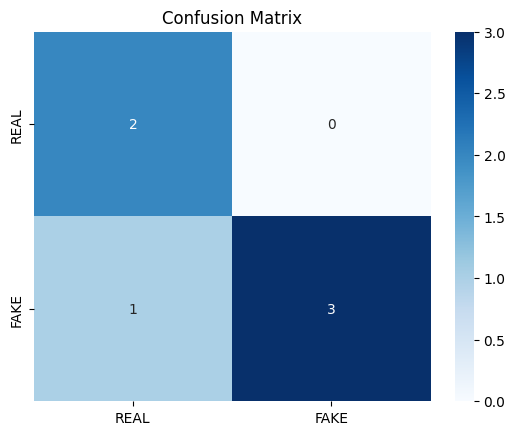

In [33]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=["REAL","FAKE"]))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["REAL","FAKE"],
            yticklabels=["REAL","FAKE"])
plt.title("Confusion Matrix")
plt.show()


In [34]:
def predict_image(path):
    img = preprocess_image(path) / 255.0
    img = np.expand_dims(img, axis=0)
    prob = model.predict(img)[0]
    label = np.argmax(prob)

    print(f"Prediction: {'FAKE' if label==1 else 'REAL'}")
    print(f"Confidence -> Real: {prob[0]*100:.2f}% | Fake: {prob[1]*100:.2f}%")

    if label == 1:
        print("Reason: Weak PRNU + abnormal frequency artifacts detected")
    else:
        print("Reason: Strong PRNU fingerprint + natural frequency patterns")

# Examples
predict_image(f"{DATASET_PATH}/Fake Images/9981.jpg")
predict_image(f"{DATASET_PATH}/Real Images/6.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: FAKE
Confidence -> Real: 0.00% | Fake: 100.00%
Reason: Weak PRNU + abnormal frequency artifacts detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: REAL
Confidence -> Real: 100.00% | Fake: 0.00%
Reason: Strong PRNU fingerprint + natural frequency patterns


In [35]:
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100

print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Validation Accuracy: {val_acc:.2f}%")


Final Training Accuracy: 100.00%
Final Validation Accuracy: 83.33%


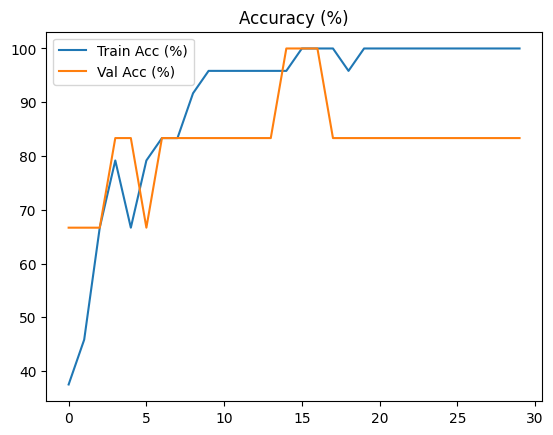

In [36]:
plt.plot(np.array(history.history['accuracy'])*100, label="Train Acc (%)")
plt.plot(np.array(history.history['val_accuracy'])*100, label="Val Acc (%)")
plt.legend()
plt.title("Accuracy (%)")
plt.show()


In [49]:
# Function to predict any image file
def predict_uploaded_image_file(path):
    # Run through the same preprocessing
    img = preprocess_image(path) / 300.0
    img = np.expand_dims(img, axis=0)
    prob = model.predict(img)[0]
    label = np.argmax(prob)

    print(f"Prediction: {'FAKE' if label==1 else 'REAL'}")
    print(f"Confidence -> Real: {prob[0]*100:.2f}% | Fake: {prob[1]*100:.2f}%")

    if label == 1:
        print("Reason: Weak PRNU + abnormal frequency artifacts detected")
    else:
        print("Reason: Strong PRNU fingerprint + natural frequency patterns")


In [45]:
predict_uploaded_image_file("/kaggle/input/prediction/8838.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: FAKE
Confidence -> Real: 0.00% | Fake: 100.00%
Reason: Weak PRNU + abnormal frequency artifacts detected


In [51]:
predict_uploaded_image_file("/kaggle/input/tb-predicted/7319.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: FAKE
Confidence -> Real: 0.07% | Fake: 99.93%
Reason: Weak PRNU + abnormal frequency artifacts detected


In [52]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, img_array, class_idx, layer_name=None):
    """
    Generate Grad-CAM heatmap for an image and a class index.
    
    model       : trained CNN
    img_array   : preprocessed image, shape (1, H, W, 3)
    class_idx   : index of the predicted class
    layer_name  : name of the last conv layer (optional)
    """
    if layer_name is None:
        # automatically use the last Conv2D layer
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.zeros(conv_outputs.shape[:2], dtype=tf.float32)

    for i in range(pooled_grads.shape[-1]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    heatmap = heatmap.numpy()

    # Resize to original image size
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    return heatmap


In [53]:
def predict_and_visualize(path):
    img = preprocess_image(path) / 255.0
    img_exp = np.expand_dims(img, axis=0)
    
    # Predict
    prob = model.predict(img_exp)[0]
    label = np.argmax(prob)

    print(f"Prediction: {'FAKE' if label==1 else 'REAL'}")
    print(f"Confidence -> Real: {prob[0]*100:.2f}% | Fake: {prob[1]*100:.2f}%")
    if label == 1:
        print("Reason: Weak PRNU + abnormal frequency artifacts detected")
    else:
        print("Reason: Strong PRNU fingerprint + natural frequency patterns")
    
    # Grad-CAM
    heatmap = grad_cam(model, img_exp, class_idx=label)
    
    # Overlay heatmap on original grayscale image
    orig = cv2.imread(path)
    orig = cv2.resize(orig, (IMG_SIZE, IMG_SIZE))
    if len(orig.shape) == 2:
        orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(orig, 0.7, heatmap, 0.3, 0)

    # Show
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM: Areas influencing prediction")
    plt.axis('off')
    plt.show()


In [58]:
predict_and_visualize("/kaggle/input/tb-predicted/7319.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: FAKE
Confidence -> Real: 0.03% | Fake: 99.97%
Reason: Weak PRNU + abnormal frequency artifacts detected


AttributeError: The layer sequential has never been called and thus has no defined output.

In [55]:
import numpy as np

# Assuming IMG_SIZE and 3 channels
dummy_input = np.random.rand(1, IMG_SIZE, IMG_SIZE, 3).astype(np.float32)
model(dummy_input)  # build the model


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.99886596, 0.00113405]], dtype=float32)>

In [57]:
model.build((None, IMG_SIZE, IMG_SIZE, 3))


In [59]:
predict_and_visualize("/kaggle/input/tb-predicted/7319.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: FAKE
Confidence -> Real: 0.03% | Fake: 99.97%
Reason: Weak PRNU + abnormal frequency artifacts detected


AttributeError: The layer sequential has never been called and thus has no defined output.